This notebook makes projections for the Gecco telescope.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jupyter_beeper
from collections import defaultdict
from matplotlib.ticker import LogLocator, NullFormatter
from hazma.gamma_ray_parameters import egret_diffuse, fermi_diffuse, comptel_diffuse, gecco_bg_model
from hazma.gamma_ray_parameters import A_eff_comptel, A_eff_egret, A_eff_fermi, energy_res_comptel, BackgroundModel
from hazma.gamma_ray_parameters import (
    gc_bg_model, default_bg_model
)
from hazma.gamma_ray_parameters import (
    gc_targets_optimistic, A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam, TargetParams, energy_res_adept, energy_res_amego, energy_res_mast, energy_res_pangu, energy_res_fermi, energy_res_egret
)
from hazma.gamma_ray_parameters import (
    A_eff_gecco, energy_res_gecco, energy_res_gecco_large, gc_targets, fornax_targets, m31_targets, draco_targets, A_eff_adept, A_eff_amego, A_eff_mast, A_eff_pangu
)

from hazma.scalar_mediator import HiggsPortal, HeavyQuark
from hazma.vector_mediator import KineticMixing, QuarksOnly
from hazma.single_channel import SingleChannelAnn, SingleChannelDec

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]
beeper = jupyter_beeper.Beeper()

def beep():
    return beeper.beep(frequency=900, secs=0.7, blocking=True)

# Setup and utils

In [17]:
# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)

In [27]:
# Other constants
T_obs_nt = 1e6  # s. From Alex.
v_mw = 1e-3
x_kd = 1e-6  # should compute this for actual models...

# Best selection of targets
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
        gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
    ),
    "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
    "m31_nfw_1_arcmin_cone": (m31_targets["nfw"]["1 arcmin cone"], gecco_bg_model),
    "draco_nfw_1_arcmin_cone": (
        draco_targets["nfw"]["1 arcmin cone"], gecco_bg_model
    )
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
    "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
    "m31_nfw_5_deg": (m31_targets["nfw"]["5 deg cone"], gecco_bg_model),
    "draco_nfw_5_deg": (
        draco_targets["nfw"]["5 deg cone"], gecco_bg_model
    )
}

def get_constraints(model, mxs):
    constraints = defaultdict(lambda: np.zeros(len(mxs)))

    for i, mx in enumerate(mxs):
        model.mx = mx

        # Constraints from existing data
        constraints["comptel"][i] = model.binned_limit(comptel_diffuse)
        constraints["egret"][i] = model.binned_limit(egret_diffuse)
        constraints["fermi"][i] = model.binned_limit(fermi_diffuse)

        # Need to optimize window for g g final state carefully. Kind of
        # hacky -- should check if model produces monochromatic lines.
        if hasattr(model, "fs") and model.fs == "g g":
            if model.kind == "ann":
                e_line = model.gamma_ray_lines(2 * model.mx)["g g"]["energy"]
            elif model.kind == "dec":
                e_line = model.gamma_ray_lines()["g g"]["energy"]
            e_window_0 = (e_line * 0.95, e_line * 1.05)
        else:
            e_window_0 = None

        # Projections
        nt_targets = nt_targets_ann if model.kind == "ann" else nt_targets_dec
        for key, (target, bg_model) in nt_targets.items():
            constraints["adept_" + key][i] = model.unbinned_limit(
                A_eff_adept, energy_res_adept, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["amego_" + key][i] = model.unbinned_limit(
                A_eff_amego, energy_res_amego, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["e-astrogam_" + key][i] = model.unbinned_limit(
                A_eff_e_astrogam, energy_res_e_astrogam, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["gecco_" + key][i] = model.unbinned_limit(
                A_eff_gecco, energy_res_gecco, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["mast_" + key][i] = model.unbinned_limit(
                A_eff_mast, energy_res_mast, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["pangu_" + key][i] = model.unbinned_limit(
                A_eff_pangu, energy_res_pangu, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )

        # CMB (s-wave)
        # TODO: not sure how this works for decaying DM...
        if model.kind == "ann":
            constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)

    return dict(constraints)

def get_constraint_label(key):
    label = key.replace("amego_", "AMEGO ")
    label = label.replace("adept_", "AdEPT ")
    label = label.replace("comptel", "COMPTEL ")
    label = label.replace("e-astrogam_", "e-ASTROGAM ")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("gecco_", "GECCO ")
    label = label.replace("mast_", "MAST ")
    label = label.replace("pangu_", "PANGU ")
    
    label = label.replace("gc_nfw_1_arcmin_cone", "(GC $1'$, NFW)")
    label = label.replace("gc_nfw_5_deg", "(GC $5^\circ$, NFW)")
    label = label.replace("gc_ein_1_arcmin_cone_optimistic", "(GC $1'$, Einasto)")
    label = label.replace("gc_ein_5_deg_optimistic", "(GC $5^\circ$, Einasto)")
    label = label.replace("m31_nfw_1_arcmin_cone", "(M31 $1'$)")
    label = label.replace("m31_nfw_5_deg", "(M31 $5^\circ$)")
    label = label.replace("draco_nfw_1_arcmin_cone", "(Draco $1'$)")
    label = label.replace("draco_nfw_5_deg", "(Draco $5^\circ$)")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

def get_formatted_fig(nrows, ncols, figsize, xlim, ylim):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for ax in axes[-1]:
        ax.set_xlabel(r"$m_\chi$ [MeV]")

    for ax in axes[:, 0]:
        ax.set_ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]")

    for ax in axes.flatten():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid()

    return fig, axes

# Model-independent constraints

## Annihilation constraints

In [7]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 100
mxs_light = np.geomspace(0.5, 250, n_mxs)
mxs_heavy = np.geomspace(60., 5e3, n_mxs)
mxs = {fs: mxs_light if fs in ["e e", "g g"] else mxs_heavy for fs in fss}

# For plotting
y_lims = {
    "e e": (1e-36, 1e-22),
    "g g": (1e-36, 1e-22),
    "mu mu": (1e-30, 1e-22),
    "pi pi": (1e-30, 1e-22),
    "pi0 pi0": (1e-30, 1e-22),
    "pi0 g": (1e-30, 1e-22),
}

In [8]:
sc_constraints = {}

for fs in fss:
    print("fs:", fs)
    model = SingleChannelAnn(1., fs, 1.)
    sc_constraints[fs] = get_constraints(model, mxs[fs])

fs: e e


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_cmb.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  return p_ann * self.mx / self.f_eff(x_kd)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:185: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


fs: g g
fs: mu mu
fs: pi pi


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:166: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


In [48]:
# # Save constraints
# np.savez("data/sv_constraints_single_channels.npz", **sc_constraints)

In [10]:
beep()

In [63]:
# # Unpack carefully...
# sc_constraints = dict(
#     np.load("data/sv_constraints_single_channels.npz", allow_pickle=True)
# )
# sc_constraints = {k: v.item() for k, v in sc_constraints.items()}

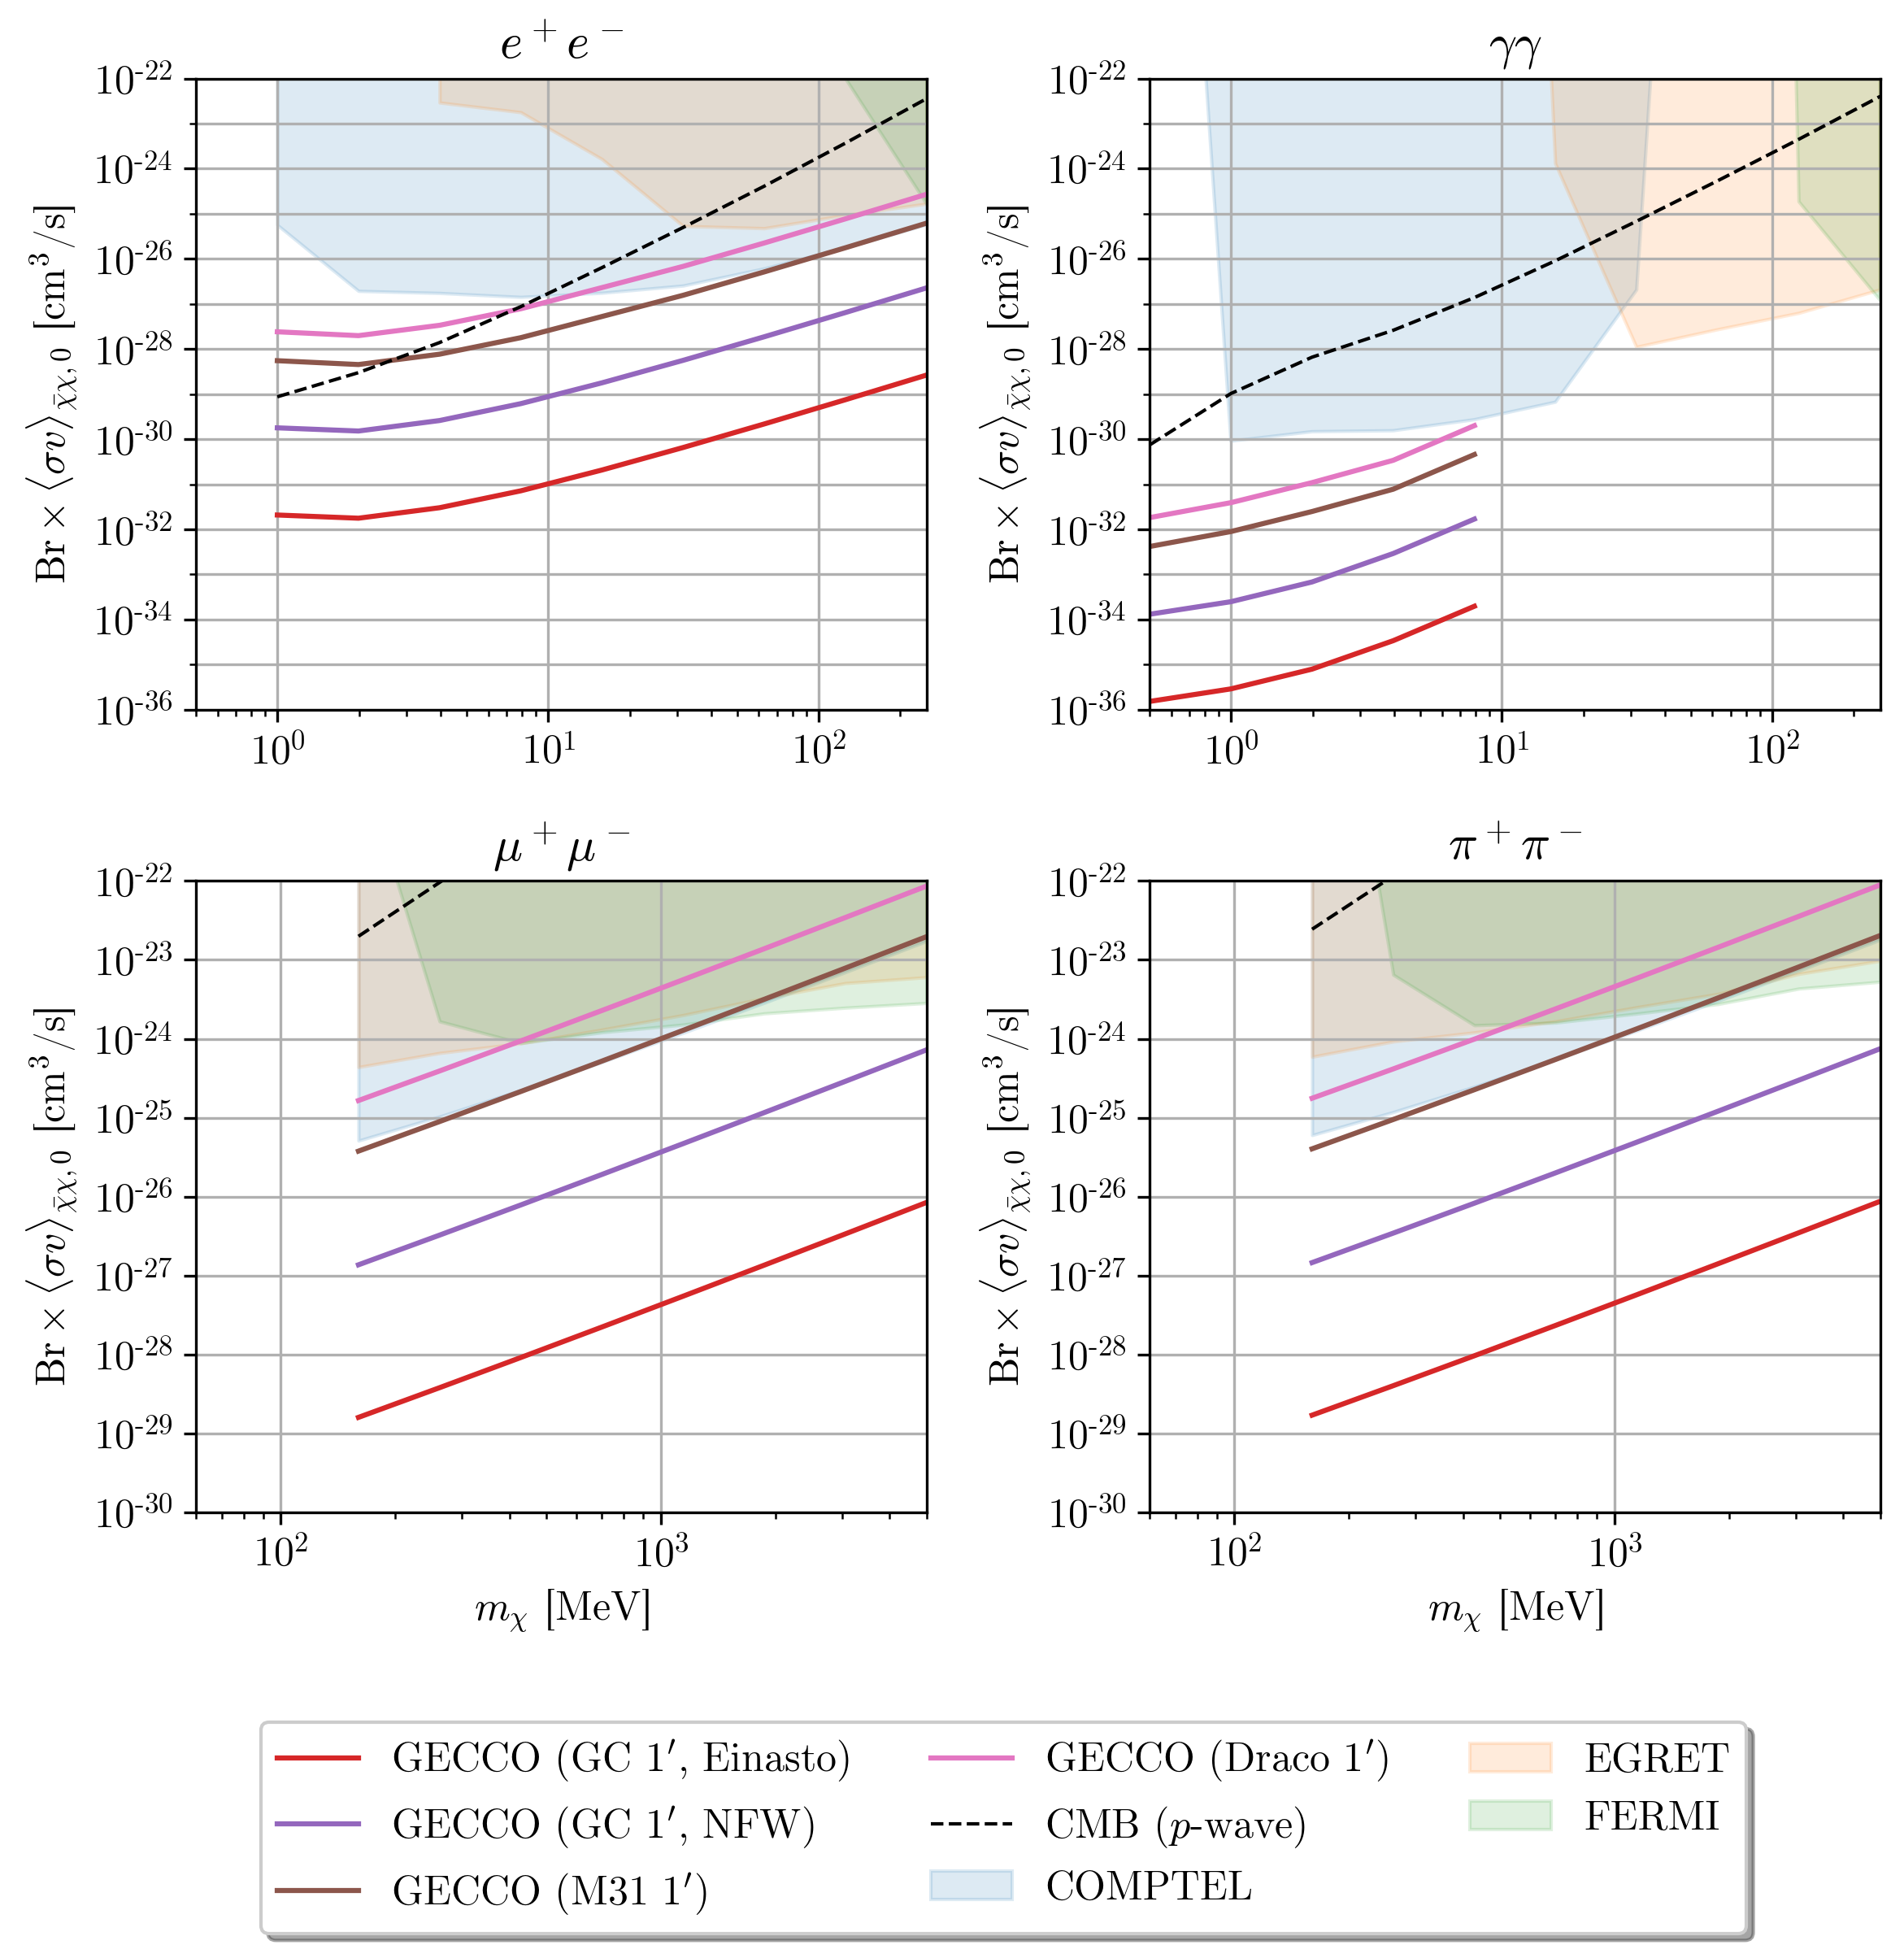

In [15]:
fig, axes = get_formatted_fig(2, 2, (4 * 2, 7), (0.5, 1e3), (1e-35, 1e-23))

for fs, ax in zip(fss, axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_ylabel(
        r"$\mathrm{Br} \times \langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]"
    )
    ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
    
    # Bradley and Cirelli's constraints
    # if fs in ["e e", "mu mu", "pi pi"]:
    #     mxs_integral, svs_integral = np.loadtxt(
    #         f"data/integral_{fs.replace(' ', '_')}.csv", unpack=True
    #     )
    #     ax.plot(mxs_integral, svs_integral, "--k")
    
    # This parameter is really weird. Just needs to be larger than the number
    # of ticks...
    n_minor_ticks = np.log10(y_lims["e e"][-1]) - np.log10(y_lims["e e"][0]) + 5
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=n_minor_ticks // 2 + 1))
    ax.yaxis.set_minor_locator(LogLocator(base=10, numticks=n_minor_ticks))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.grid(True, which='both')
    
    for color, (key, svs) in zip(colors, sc_constraints[fs].items()):
        if key == "cmb":
            # # s-wave
            # ax.plot(mxs[fs], svs, "-.k", linewidth=1, label=r"CMB ($s$-wave)")
            # p-wave
            v_cmbs = 2e-4 * (0.235) * (1 / mxs[fs]) * np.sqrt(1e-4 / x_kd)
            ax.plot(
                mxs[fs], svs * (v_mw / v_cmbs)**2, "--k", linewidth=1,
                label=r"CMB ($p$-wave)"
            )
        elif "gecco" not in key:
            # Existing constraints
            ax.fill_between(
                mxs[fs], svs, y2=1e-20, label=get_constraint_label(key), alpha=0.15,
                color=color
            )
            # ax.plot(
            #     mxs[fs], svs, "-", linewidth=0.75, label=get_constraint_label(key)
            # )
        else:
            ax.plot(mxs[fs], svs, label=get_constraint_label(key), color=color)

fig.tight_layout()

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.2, -0.3), fancybox=True, shadow=True, ncol=3
)

# fig.savefig("figures/gecco/single_channel_sigmav_limits.pdf", bbox_inches="tight")

## Decay constraints

This is a hack for now. The decaying DM's mass is equal to `2 mx`!

In [77]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 100
mxs_light = np.geomspace(1, 1e3, n_mxs)
mxs_heavy = np.geomspace(1e2, 1e4, n_mxs)
mxs = {fs: mxs_light if fs in ["e e", "g g"] else mxs_heavy for fs in fss}

# For plotting
y_lims = {
    "e e": (1e22, 1e32),
    "g g": (1e22, 1e32),
    "mu mu": (1e22, 1e28),
    "pi pi": (1e22, 1e28),
}

In [78]:
sc_constraints = {}

for fs in fss:
    print("fs:", fs)
    model = SingleChannelDec(1., fs, 1.)
    sc_constraints[fs] = get_constraints(model, mxs[fs])

fs: e e


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:353: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


fs: g g
fs: mu mu


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)


fs: pi pi


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:334: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [79]:
# Save constraints
np.savez("data/gamma_constraints_single_channels.npz", **sc_constraints)

In [80]:
beep()

In [23]:
# # Unpack carefully...
# sc_constraints = dict(
#     np.load("data/gamma_constraints_single_channels.npz", allow_pickle=True)
# )
# sc_constraints = {k: v.item() for k, v in sc_constraints.items()}

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


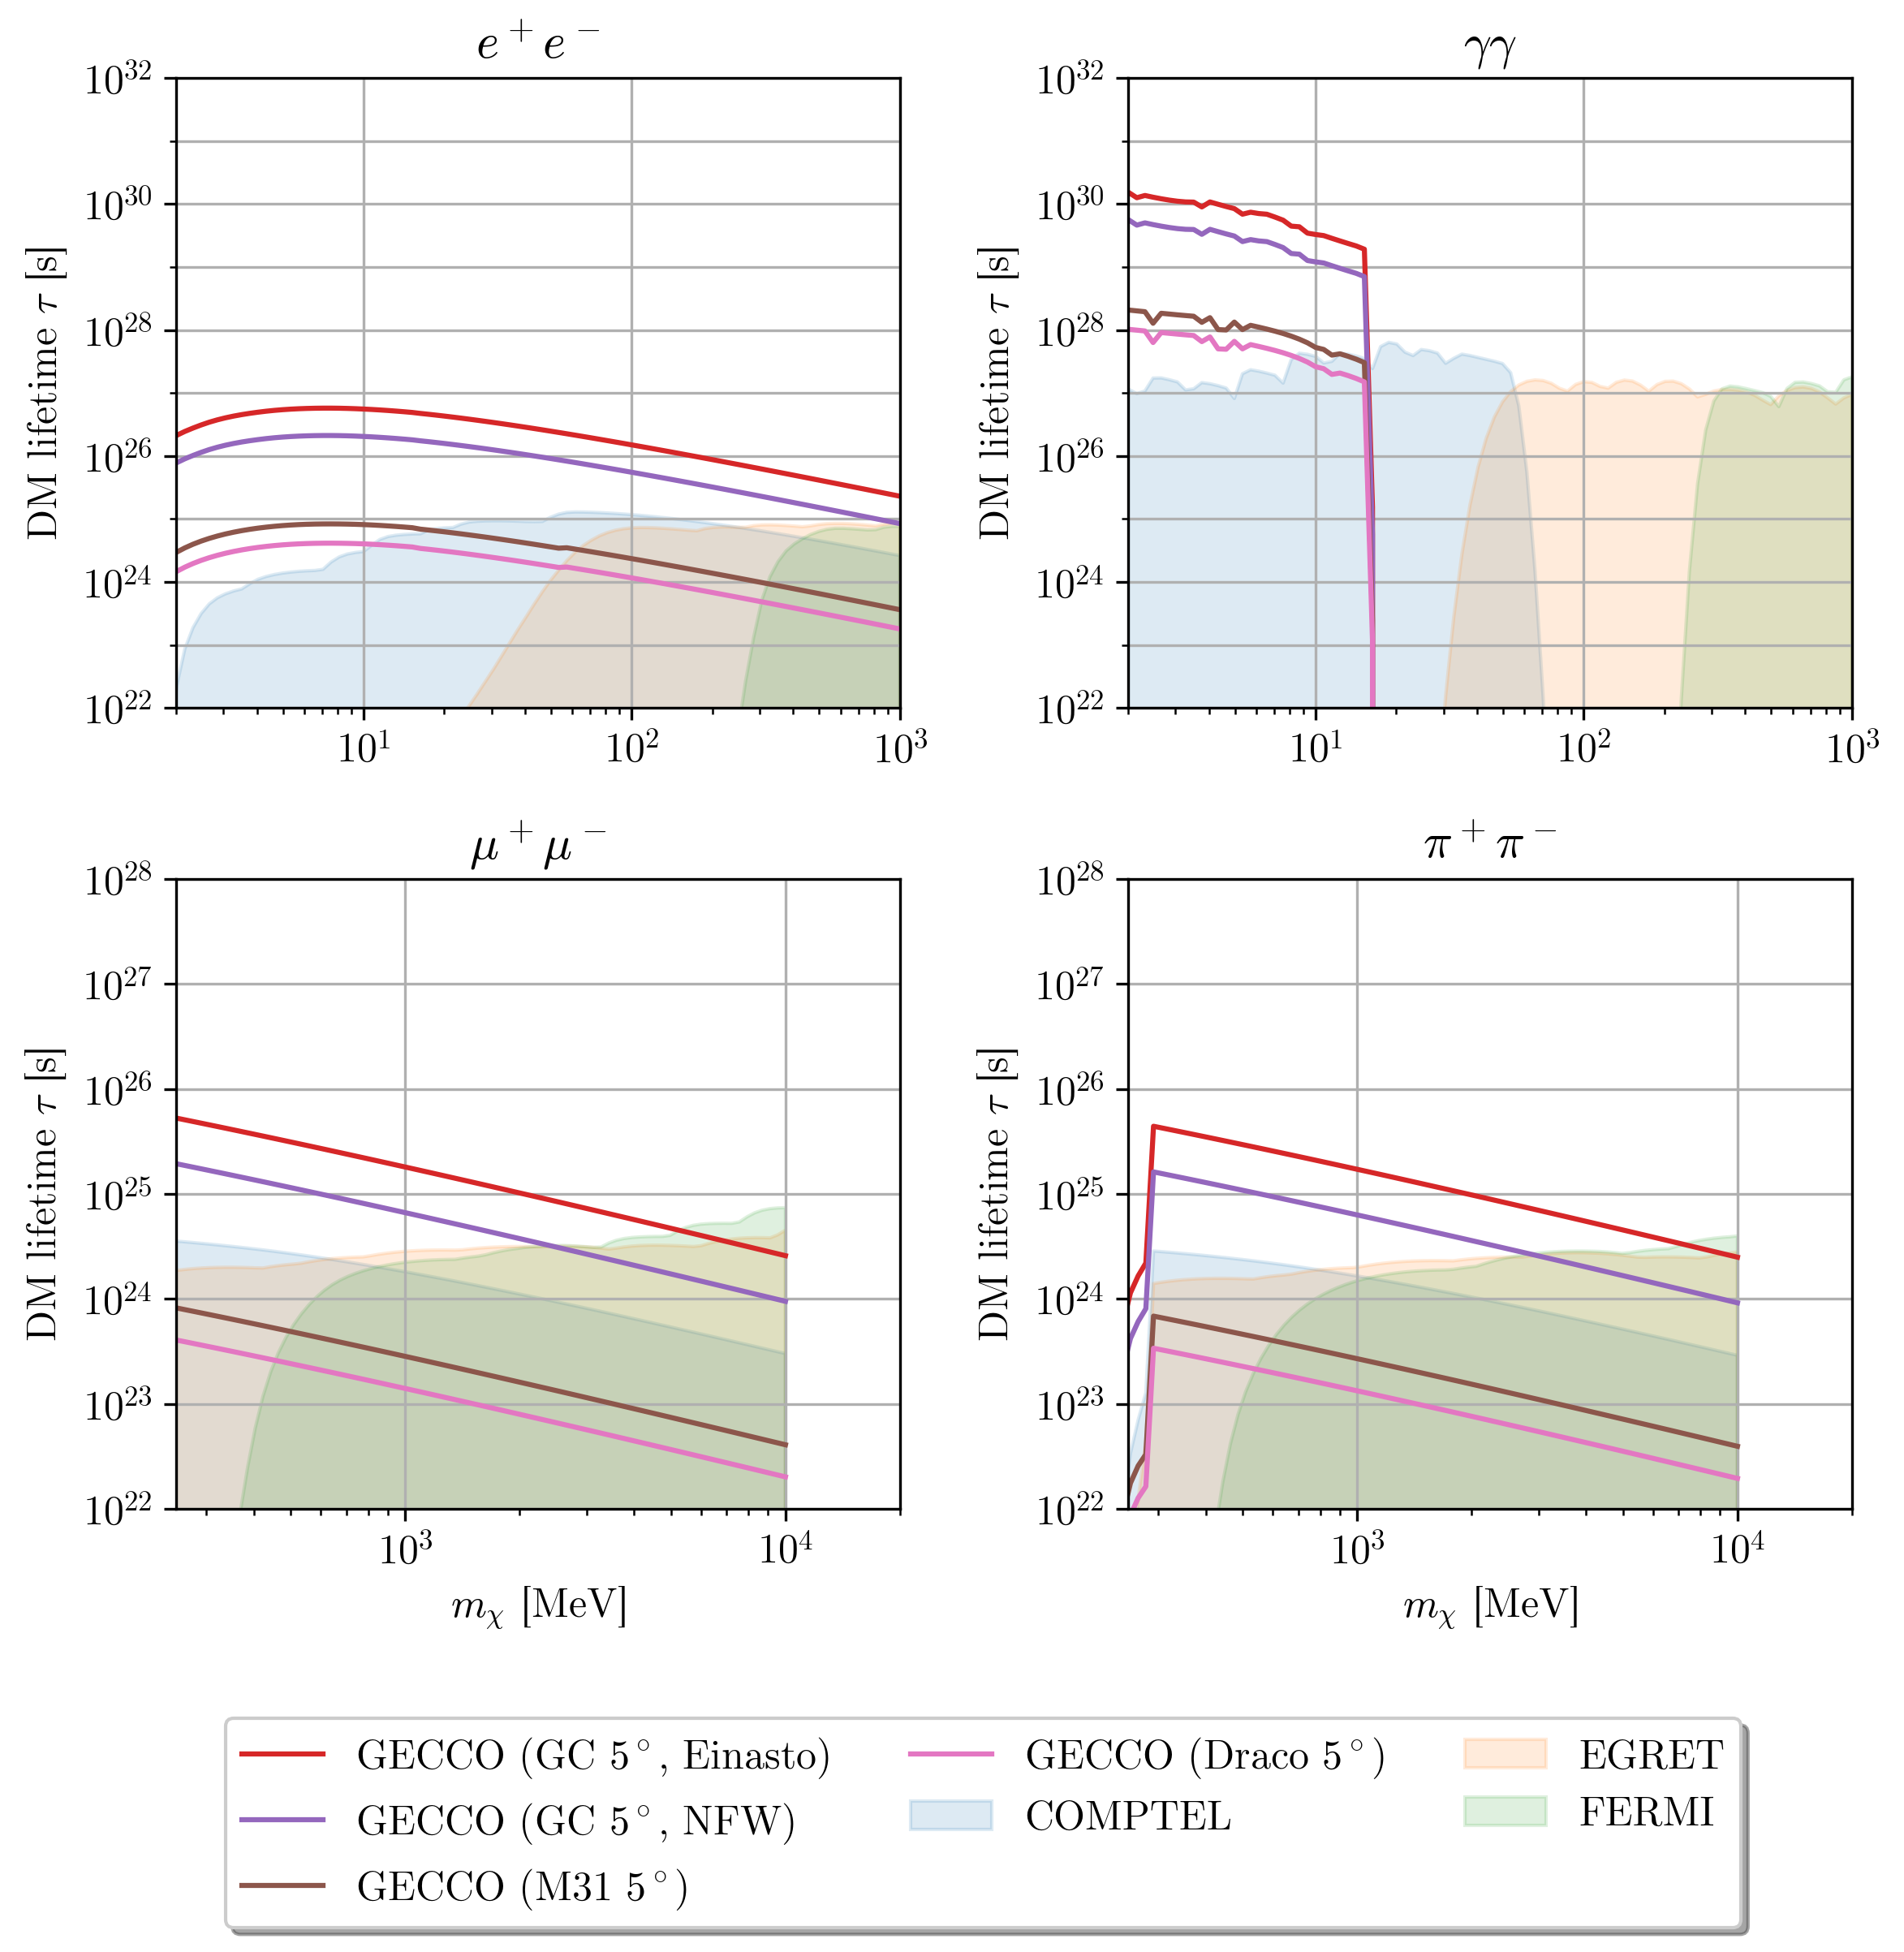

In [81]:
fig, axes = get_formatted_fig(2, 2, (4 * 2, 7), (0.5, 1e3), (1e20, 1e32))

for fs, ax in zip(fss, axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_ylabel(r"DM lifetime $\tau$ [s]")
#     ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
    
    # This parameter is really weird. Just needs to be larger than the number
    # of ticks...
    n_minor_ticks = np.log10(y_lims["e e"][-1]) - np.log10(y_lims["e e"][0]) + 5
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=n_minor_ticks // 2 + 1))
    ax.yaxis.set_minor_locator(LogLocator(base=10, numticks=n_minor_ticks))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.grid(True, which='both')
    
    for color, (key, gamma) in zip(colors, sc_constraints[fs].items()):
        if key == "cmb":
            pass
        elif "gecco" not in key:
            # Existing constraints
            ax.fill_between(
                mxs[fs], 1 / gamma, y2=1e-20,
                label=get_constraint_label(key), alpha=0.15, color=color
            )
        else:
            ax.plot(mxs[fs], 1 / gamma, label=get_constraint_label(key), color=color)

fig.tight_layout()

for ax in axes[0]:
    ax.set_xlim(2, 1e3)

for ax in axes[1]:
    ax.set_xlim(2.5e2, 2e4)

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.2, -0.3), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/single_channel_lifetime_limits.pdf", bbox_inches="tight")

# PBH constraints

Need to debug. Maybe there's numerical over/underflow?

In [19]:
from hazma.theory import TheoryDec
from hazma.parameters import g_to_MeV, MeV_to_g, Msun_to_g, g_to_Msun
from scipy.interpolate import interp1d

In [20]:
from itertools import cycle

def plot_bounds(bounds, ax, labels=[]):
    for bound, label in zip(bounds, cycle(labels)):
        m_pbhs, f_pbhs = np.loadtxt(
            f"../../../../PBHbounds/bounds/{bound}.txt", unpack=True
        )
        ax.fill_between(
            x=m_pbhs * Msun_to_g, y1=f_pbhs, y2=2,
            label=label, alpha=0.2
        )
        
class PBH(TheoryDec):
    def __init__(
        self, mx, f_pbh_dummy=1, m_pbh_min=1e15, m_pbh_max=1e18, n_pbh=30,
        spectrum_kind="both"
    ):
        """
        :param mx: PBH mass in MeV
        """
        # Masses corresponding to data file's columns
        self._mxs = np.geomspace(
            m_pbh_min, m_pbh_max, n_pbh
        ) * g_to_MeV
        self._data_primary = np.loadtxt(
            f"data/pbh_primary_spectra.csv", delimiter=","
        )
        self._data_secondary = np.loadtxt(
            f"data/pbh_secondary_spectra.csv", delimiter=","
        )
        
        self.spectrum_kind = spectrum_kind
        self.f_pbh_dummy = f_pbh_dummy
        # Must call after setting everything else up
        self.mx = mx
    
    @property
    def mx(self):
        return self._mx
    
    @mx.setter
    def mx(self, mx):
        self._mx = mx
        
        # Select column for PBH mass
        idx = np.where(self._mxs == mx)[0][0] + 1
        
        # NOTE: d^2N/dE dt is an abuse of notation, but works for getting f_pbh
        # constraints!
        if self.spectrum_kind == "primary":
            # 1/GeV/s -> 1/MeV/s
            fn = interp1d(
                self._data_primary[:, 0] * 1e3,
                self._data_primary[:, idx] * 1e-3,
                bounds_error=False,
                fill_value=0
            )
        elif self.spectrum_kind == "secondary":
            # 1/GeV/s -> 1/MeV/s
            fn = interp1d(
                self._data_secondary[:, 0] * 1e3,
                self._data_secondary[:, idx] * 1e-3,
                bounds_error=False,
                fill_value=0
            )
        else:
            raise ValueError("invalid spectrum_kind")
        
        self._spectrum_funcs = lambda: {"all": fn}
    
    @staticmethod
    def list_final_decay_states():
        return ["all"]
    
    def _decay_widths(self):
        return {"all": self.f_pbh_dummy}
    
    def _gamma_ray_line_energies(self):
        return {}

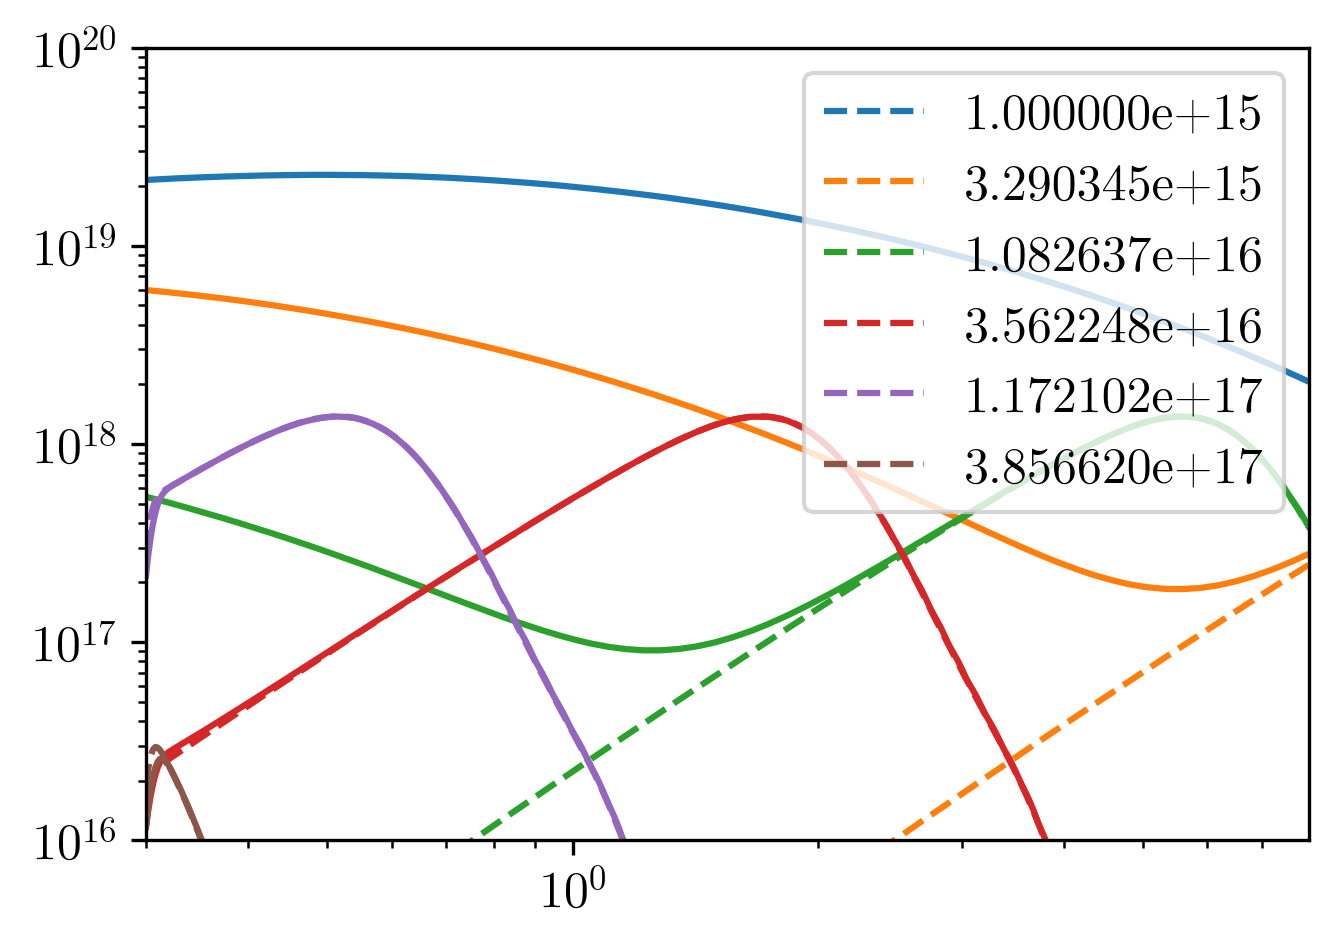

In [6]:
e_gams = np.geomspace(0.3, 7.982, 500)

mxs = np.geomspace(1e15, 1e18, 30) * g_to_MeV

for mx, color in zip(mxs[::5], colors):
    pbh = PBH(mx, spectrum_kind="primary")
    plt.loglog(
        e_gams,
        pbh.total_conv_spectrum_fn(0.3, 7.9829, energy_res_gecco)(e_gams),
        "--", label=f"{pbh.mx*MeV_to_g:e}", color=color
    )

    pbh = PBH(mx, spectrum_kind="secondary")
    plt.loglog(
        e_gams,
        pbh.total_conv_spectrum_fn(0.3, 7.9829, energy_res_gecco)(e_gams),
        color=color
    )

    plt.xlim(e_gams[[0, -1]])
    plt.ylim(1e16, 1e20)

plt.legend()

In [21]:
pbh = PBH(1e15 * g_to_MeV, spectrum_kind="secondary")
f_pbh_constraints = get_constraints(pbh, pbh._mxs)

m_pbhs = pbh._mxs * MeV_to_g

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 101215.995655 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 10017.780306 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 0.154866 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 4001.804926 MeV.
  % es_out_of_bounds[0]


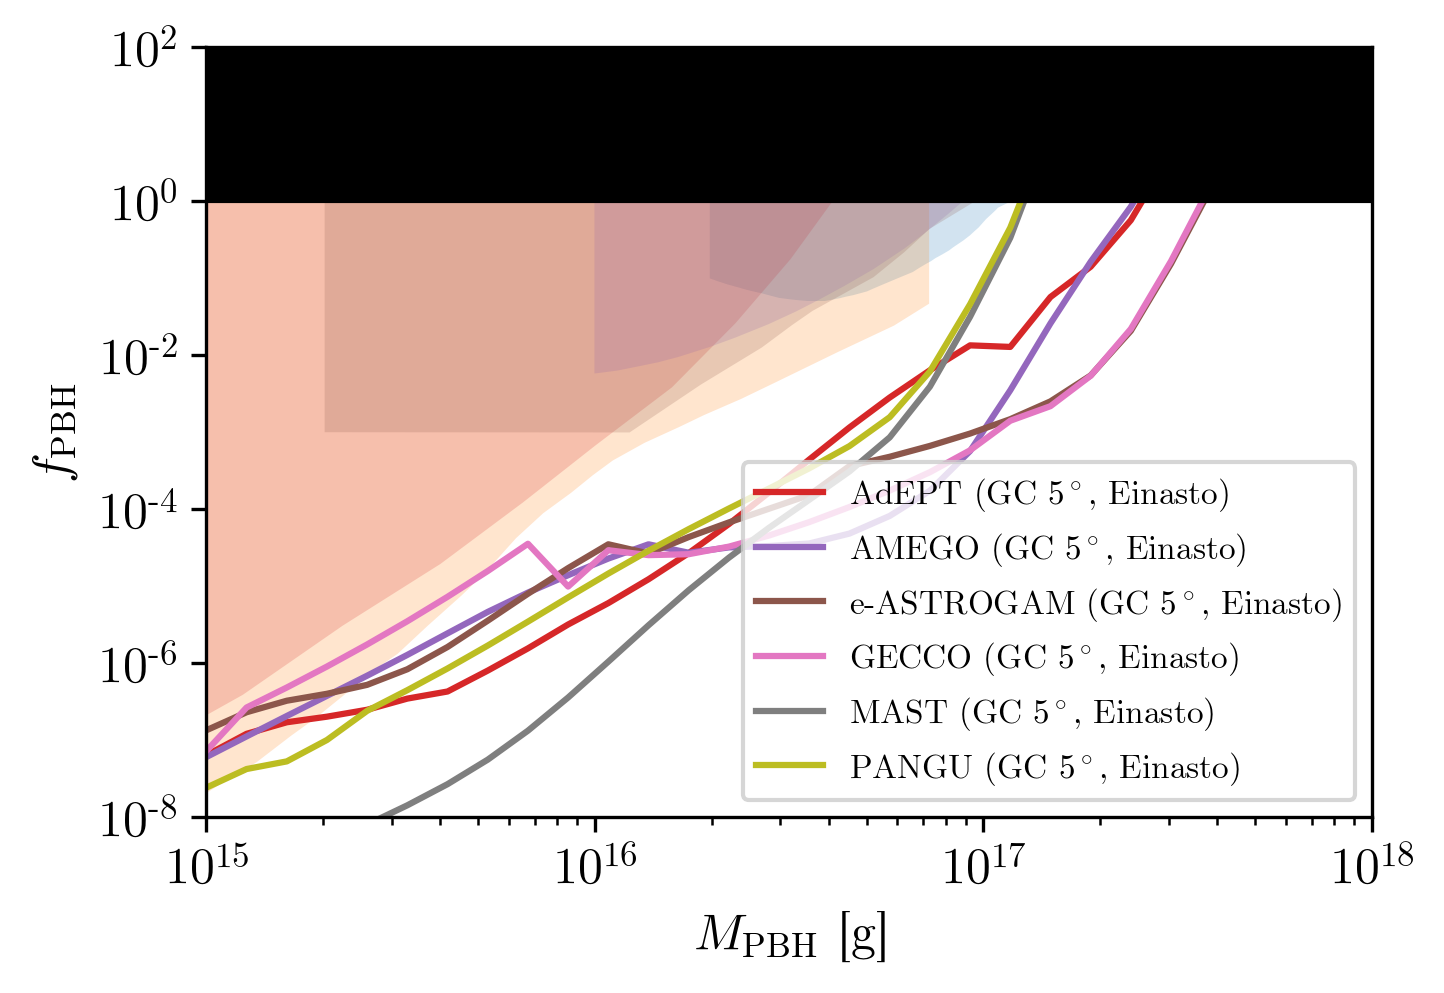

In [56]:
for color, (key, f_pbhs) in zip(cycle(colors), f_pbh_constraints.items()):
    if key in ["fermi", "egret"]:
        continue
    else:
        if "gc_ein" not in key or "5_deg" not in key:
            continue

        plt.loglog(m_pbhs, f_pbhs, label=get_constraint_label(key), color=color)

bounds = ["INTEGRAL", "EDGESevap", "CMB", "Voyager", "511keV", "EGRB"]
plot_bounds(bounds, plt.gca(), labels=[None])#, "goldenrod")

plt.xlabel(r"$M_\mathrm{PBH}$ [g]")
plt.ylabel(r"$f_\mathrm{PBH}$")
plt.fill_between([1e14, 1e30], y1=1, y2=10000, zorder=100, color="k")
plt.xlim(1e15, 1e18)
# plt.ylim(1e-6, 2)
plt.ylim(1e-8, 1e2)
plt.legend(fontsize=8, loc="lower right")

plt.tight_layout()
# plt.savefig(f"figures/gecco/pbh_bounds_{pbh.spectrum_kind}.pdf")

# Higgs portal model

In [8]:
mss = [200, 1000]

sm_args = np.array([
    [{"mx": 1., "ms": ms, "gsxx": 1., "stheta": 0.1} for ms in mss],
    [{"mx": 1., "ms": ms, "gsxx": 1., "gsQ": 0.1, "mQ": 1000, "QQ": 1} for ms in mss],
])

SMs = np.array([
    [HiggsPortal, HiggsPortal],
    [HeavyQuark, HeavyQuark]
])

# Instantiate all the models
sms = np.vectorize(lambda SM, kwargs: SM(**kwargs))(SMs, sm_args)

In [29]:
# Recompute constraints
sv_constraints_sms = np.empty_like(sms)
for i in range(len(sms)):
    for j in range(len(sms[i])):
        sv_constraints_sms[i, j] = get_sv_constraints(sms[i, j], mxs)

# Save results
# np.savez(
#     "data/sv_constraints_sms.npz", sv_constraints_sms=sv_constraints_sms, sm_args=sm_args
# )

# sv_constraints_sms = np.load(
#     "data/sv_constraints_sms.npz", allow_pickle=True
# )["sv_constraints_sms"]

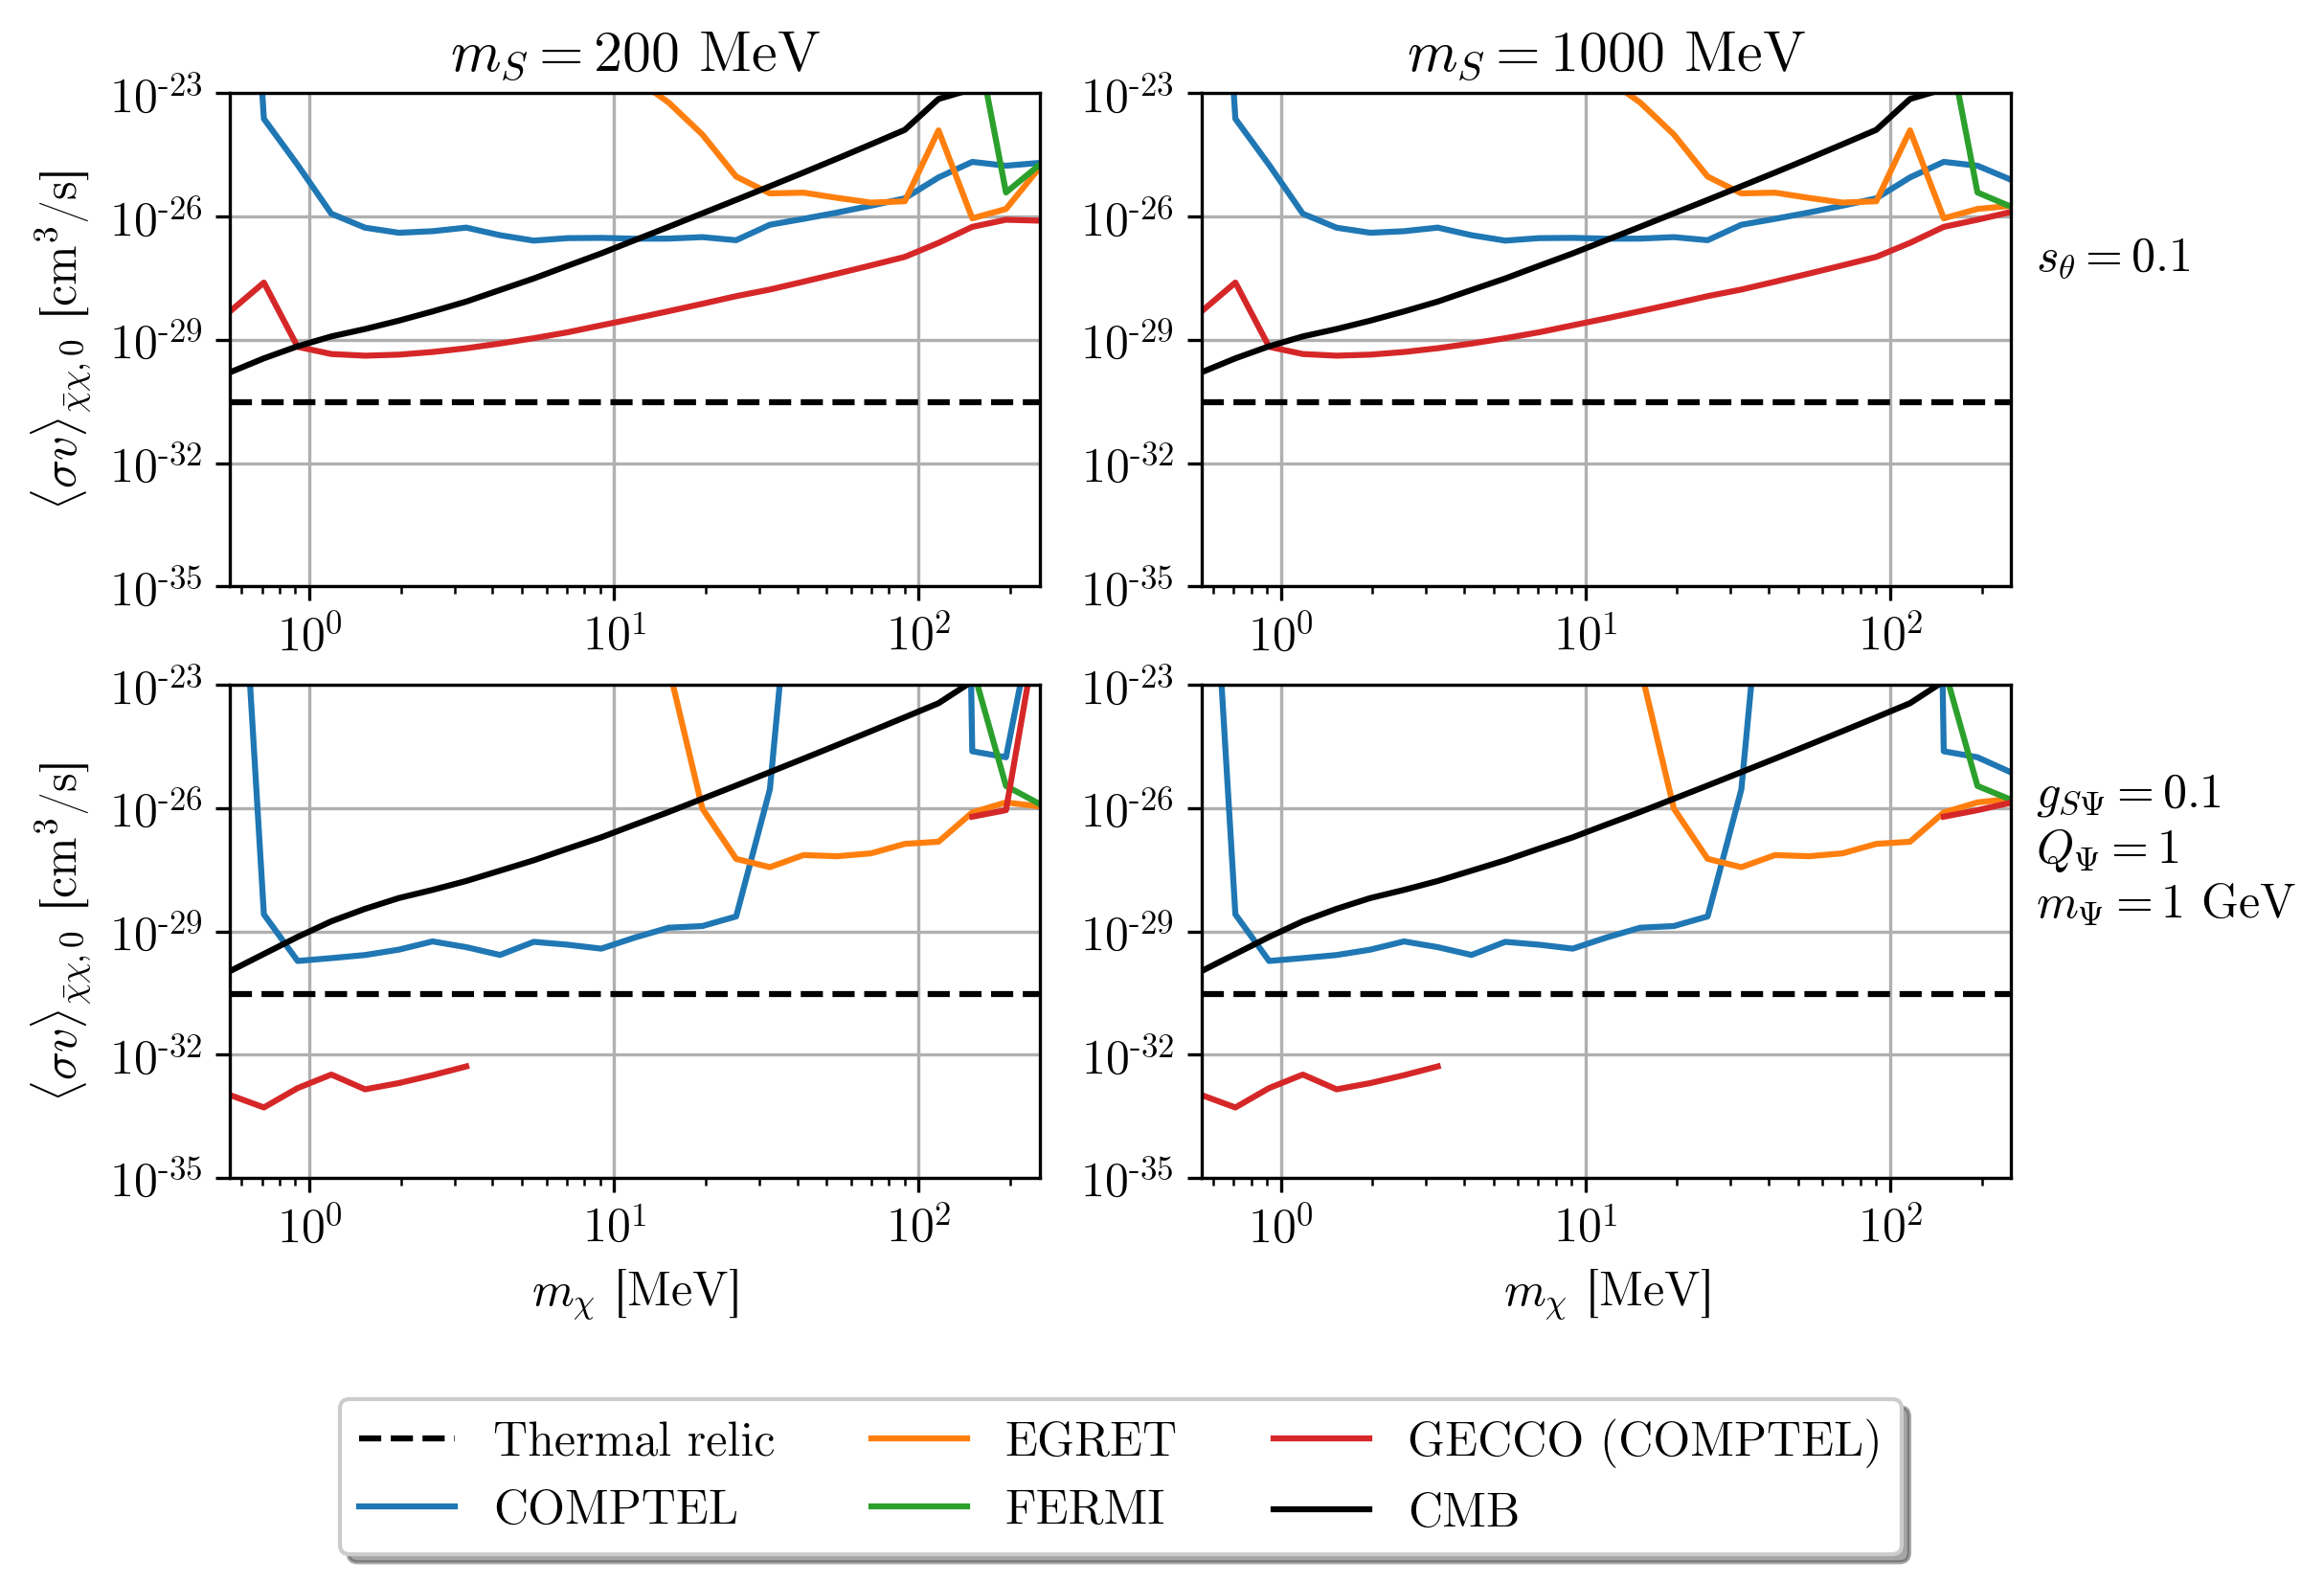

In [35]:
fig, axes = get_formatted_fig(
    *sms.shape, (4 * sms.shape[1], 2.5 * sms.shape[0]),
    mxs[[0, -1]], (1e-35, 1e-23)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Relic cross section tranlated to <sigma v> in the Milky Way
        v_fo = np.sqrt(1/10)
        ax.axhline(
            3e-26 * (v_mw / v_fo)**2, linestyle="--", color="k", label="Thermal relic"
        )
        
        # Constraints
        for key, svs in sv_constraints_sms[i, j].items():
            if key in ["comptel_check", "gecco_large", "e_astrogam", 'gecco_gc', 'gecco_egret', 'gecco_fermi', 'gecco_draco']:
                continue
            elif key == "cmb":
                v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
                ax.plot(mxs, svs * (v_mw / v_cmbs)**2, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
for ms, ax in zip(mss, axes[0]):
    ax.set_title(r"$m_S = $" + f"{ms} MeV")

# Coupling labels  ---------------
row_labels = [
    r"$s_\theta = %.1f$" % sms[0, -1].stheta,
    r"$g_{S\Psi} = %.1f$" % sms[1, -1].gsQ + "\n"
    + r"$Q_\Psi = %i$" % sms[1, -1].QQ + "\n"
    + r"$m_\Psi = %i$ GeV" % (sms[1, -1].mQ / 1000)
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/sm_comptel.png", bbox_inches="tight")

In [9]:
beep()

## Understanding gap in heavy quark model

In [13]:
mxs = np.geomspace(mx_min, mx_max, 100)

sv_gecco = np.zeros(len(mxs))
sm = sms[1, 1]

for i, mx in enumerate(mxs):
    sm.mx = mx
    print(mx)
    sv_gecco[i] = sm.unbinned_limit(
        A_eff_gecco, energy_res_gecco, T_obs_nt, comptel_diffuse.target,
        default_bg_model, debug_msgs=True
    )

0.55
	e_a, e_b = 0.46166663340637953, 0.5832855772083002; -1650.1877330616312
0.5850687538727356
	e_a, e_b = 0.5688893083466786, 0.6076641248626786; -3297.7788732531467
0.6223735395603557
	e_a, e_b = 0.5901052765254281, 0.661704277667332; -2641.095659218302
0.6620569295162563
	e_a, e_b = 0.6504360397663269, 0.7518234754380413; -2483.461460922321
0.7042705868088829
	e_a, e_b = 0.6881883404450958, 1.2051027848767886; -1439.2876843023926
0.7491758447518061
	e_a, e_b = 0.7325068922628875, 0.7934190558641931; -3597.360608530171
0.7969443234918057
	e_a, e_b = 0.788448759978593, 0.805644754036132; -5992.911670499436
0.8477585859114564
	e_a, e_b = 0.8305963500103407, 1.231082542954647; -1864.444298716217
0.9018128353529603
	e_a, e_b = 0.8828299818187394, 0.9305636259639914; -4932.355754454972
0.9593136578298089
	e_a, e_b = 0.9335812662709343, 0.9829360328746231; -5176.451984377609
1.0204808115628765
	e_a, e_b = 1.0148423109768703, 1.071927686285044; -4121.173844633162
1.0855480668584183
	e_a, 

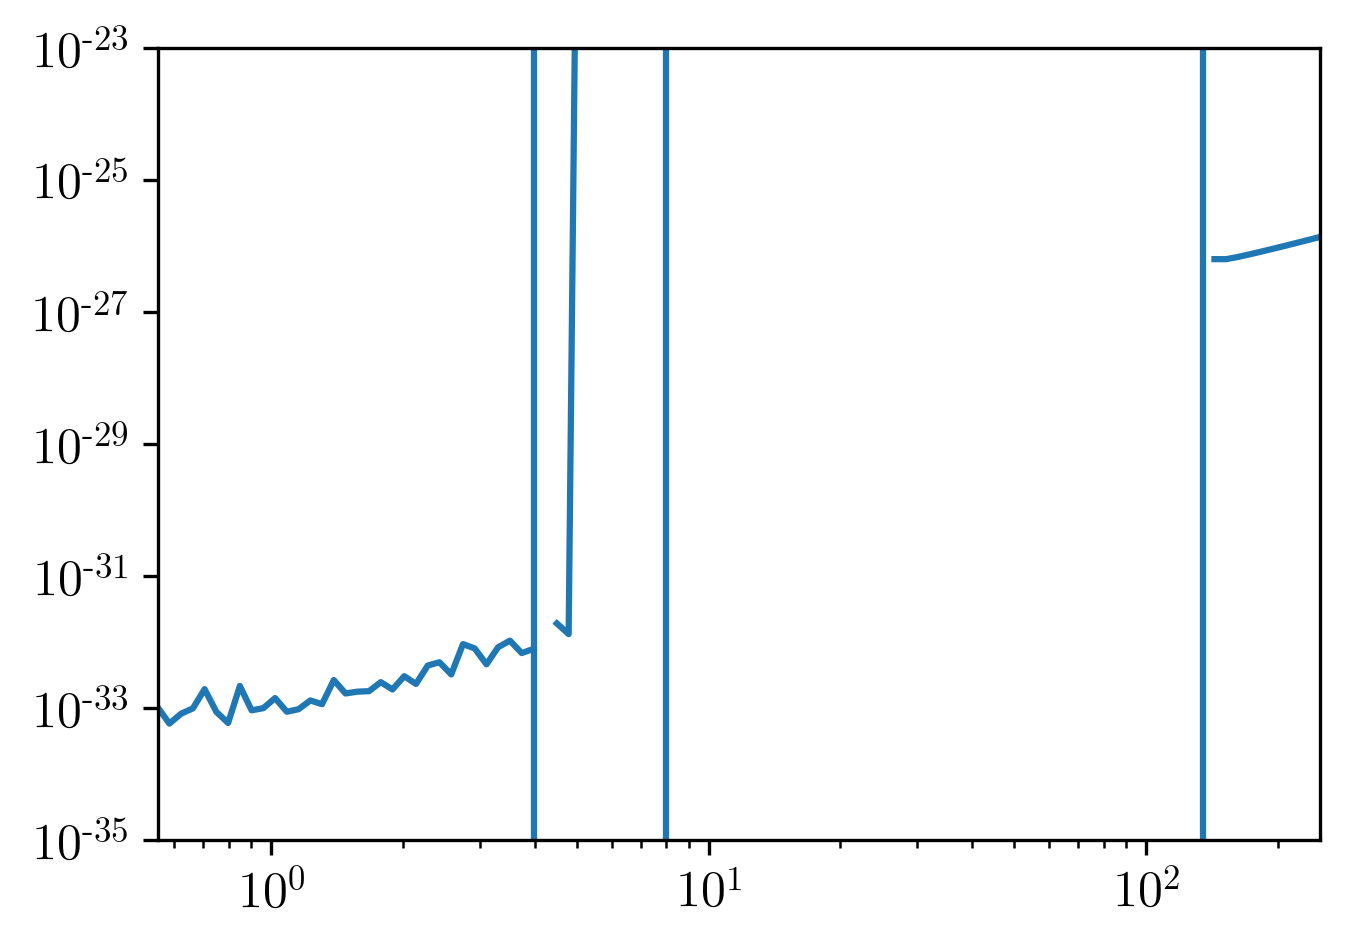

In [16]:
plt.loglog(mxs, sv_gecco)
plt.xlim(mxs[[0, -1]])
plt.ylim(1e-35, 1e-23)
plt.axvline(0.3)
plt.axvline(7.98/2)
plt.axvline(7.98)
plt.axvline(135)

# Vector

In [32]:
mvs = [200, 1000]

vm_args = np.array([
    [{"mx": 1., "mv": mv, "gvxx": 1., "eps": 0.1} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": -1, "gvss": 0.} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": 1, "gvss": 0.} for mv in mvs]
])

VMs = np.array([
    [KineticMixing, KineticMixing],
    [QuarksOnly, QuarksOnly],
    [QuarksOnly, QuarksOnly]
])

# Instantiate all the models
vms = np.vectorize(lambda VM, args: VM(**args))(VMs, vm_args)

In [33]:
# Recompute constraints
sv_constraints_vms = np.empty_like(vms)
for i in range(len(vms)):
    for j in range(len(vms[i])):
        sv_constraints_vms[i, j] = get_sv_constraints(vms[i, j], mxs)

# Save results
np.savez(
    "data/sv_constraints_vms.npz", sv_constraints_vms=sv_constraints_vms, vm_args=vm_args
)

# # Load precomputed constraints
# sv_constraints_vms = np.load(
#     "data/sv_constraints_vms.npz", allow_pickle=True
# )["sv_constraints_vms"]

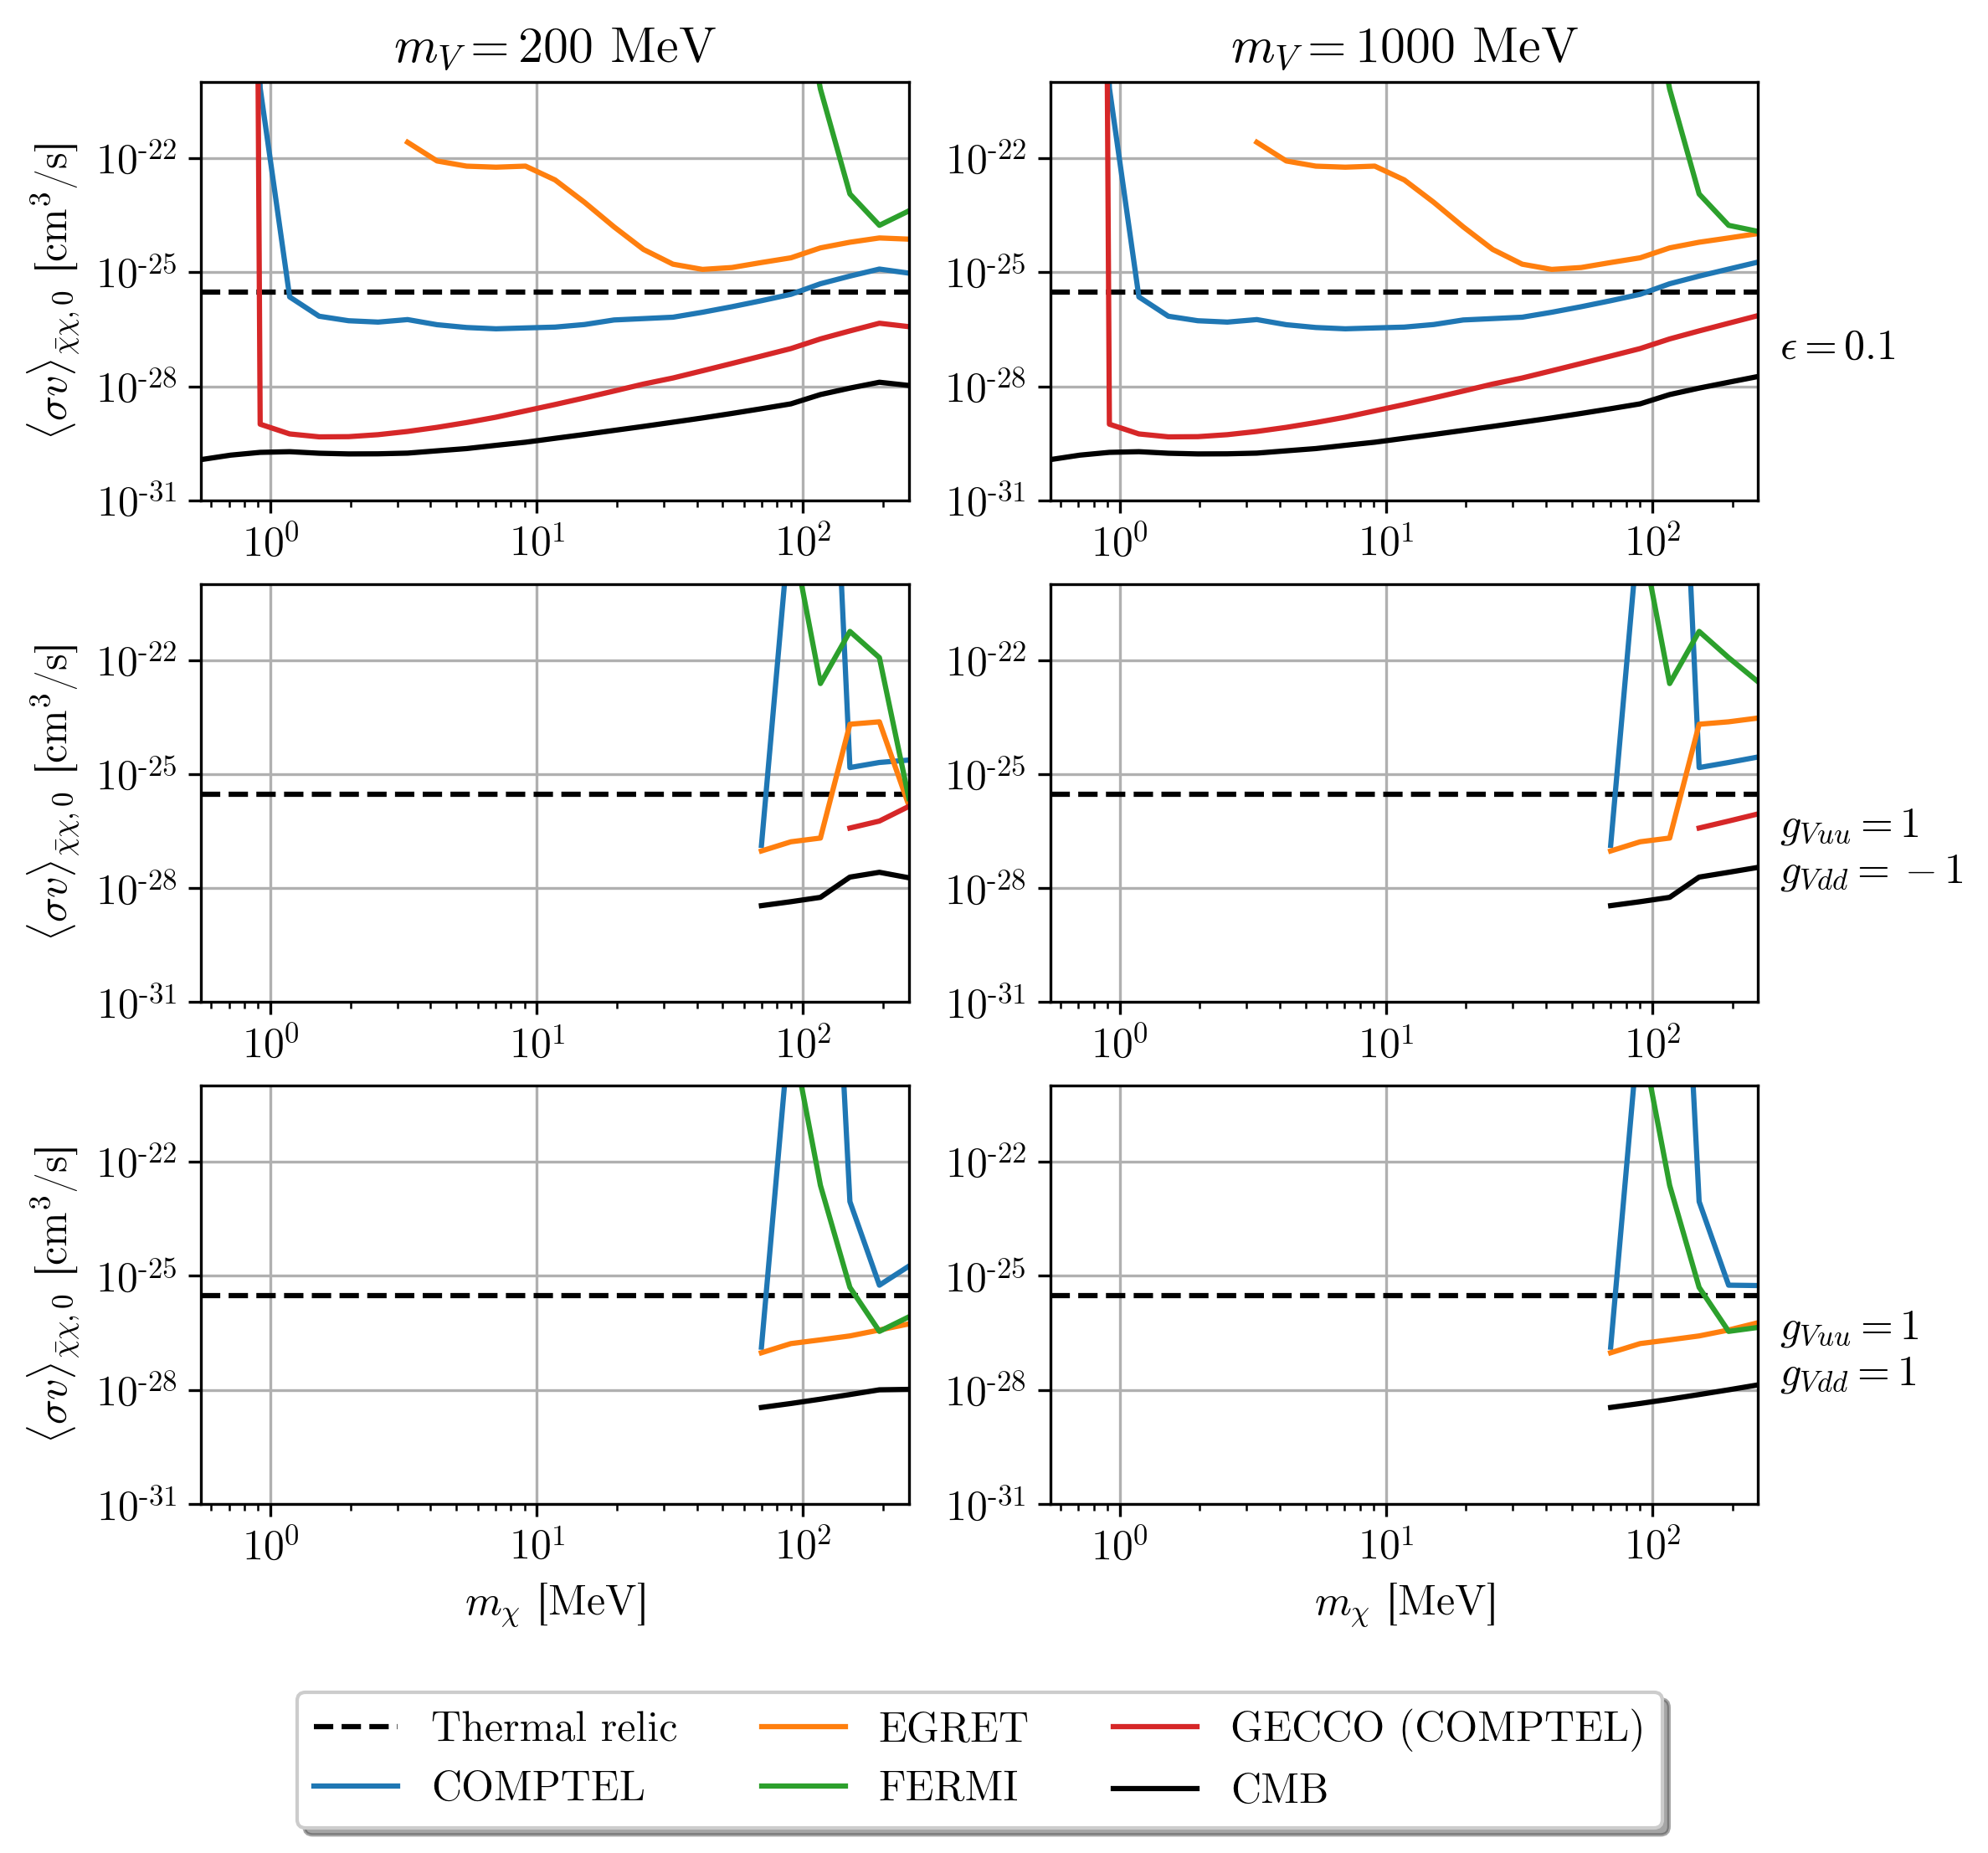

In [36]:
fig, axes = get_formatted_fig(
    *vms.shape, (4 * vms.shape[1], 2.5 * vms.shape[0]),
    mxs[[0, -1]], (1e-31, 1e-20)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle="--", color="k", label="Thermal relic")
        
        # Constraints
        for key, svs in sv_constraints_vms[i, j].items():
            if key in ["comptel_check", "gecco_large", "e_astrogam", 'gecco_gc', 'gecco_egret', 'gecco_fermi', 'gecco_draco']:
                continue
            elif key == "cmb":
                ax.plot(mxs, svs, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
for mv, ax in zip(mvs, axes[0]):
    ax.set_title(r"$m_V = $" + f"{mv} MeV")

# Coupling labels
row_labels = [
    r"$\epsilon = %.1f$" % vms[0, -1].eps,
    r"$g_{Vuu} = %i$" % vms[1, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[1, -1].gvdd,
    r"$g_{Vuu} = %i$" % vms[2, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[2, -1].gvdd,
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/vm_comptel.png", bbox_inches="tight")

In [38]:
T_obs_nt / 1e6

1.0

In [24]:
beeper.beep(frequency=900, secs=0.7, blocking=True)

# Debugging model-independent class

In [8]:
mx = 75
sm = HiggsPortal(mx, 1e3, 1, 0.1)
sc_pi0_g = SingleChannel(mx, "pi0 g", 1)
sc_pi_pi = SingleChannel(mx, "pi pi", 1)
sc_mu_mu = SingleChannel(mx, "mu mu", 1)
sc_e_e = SingleChannel(mx, "e e", 1)

In [9]:
e_gams = np.geomspace(5e0, 3e2, 1000)
e_cm = 2 * mx * (1 + 1e-3**2)

In [10]:
sc_pi0_g.sigma(e_cm)

1

In [11]:
sc_pi0_g.annihilation_cross_sections(e_cm)

{'pi0 g': 1, 'total': 1}

(1e-05, 1.0)

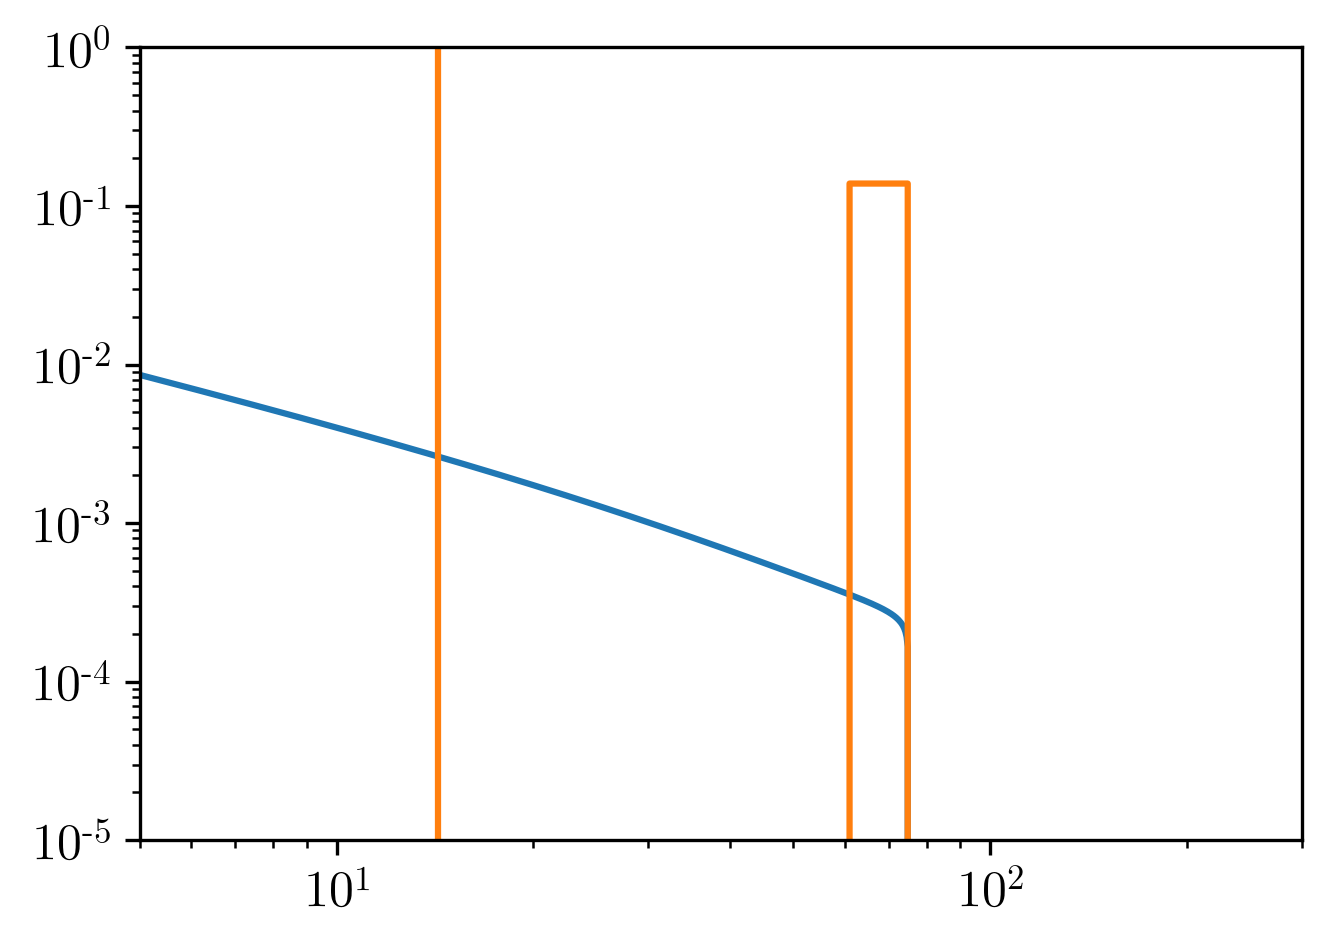

In [13]:
plt.loglog(e_gams, sm.total_spectrum(e_gams, e_cm))
# plt.loglog(e_gams, sc_pi_pi.total_spectrum(e_gams, e_cm) * 1/3 + sc_pi0_pi0.total_spectrum(e_gams, e_cm) * 1/5)
plt.loglog(e_gams, sc_pi0_g.total_spectrum(e_gams, e_cm))
try:
    plt.axvline(sc_pi0_g.gamma_ray_lines(e_cm)["pi0 g"]["energy"], color=colors[1])
except KeyError:
    pass

plt.xlim(e_gams[[0, -1]])
plt.ylim(1e-5, 1e0)

# Background models

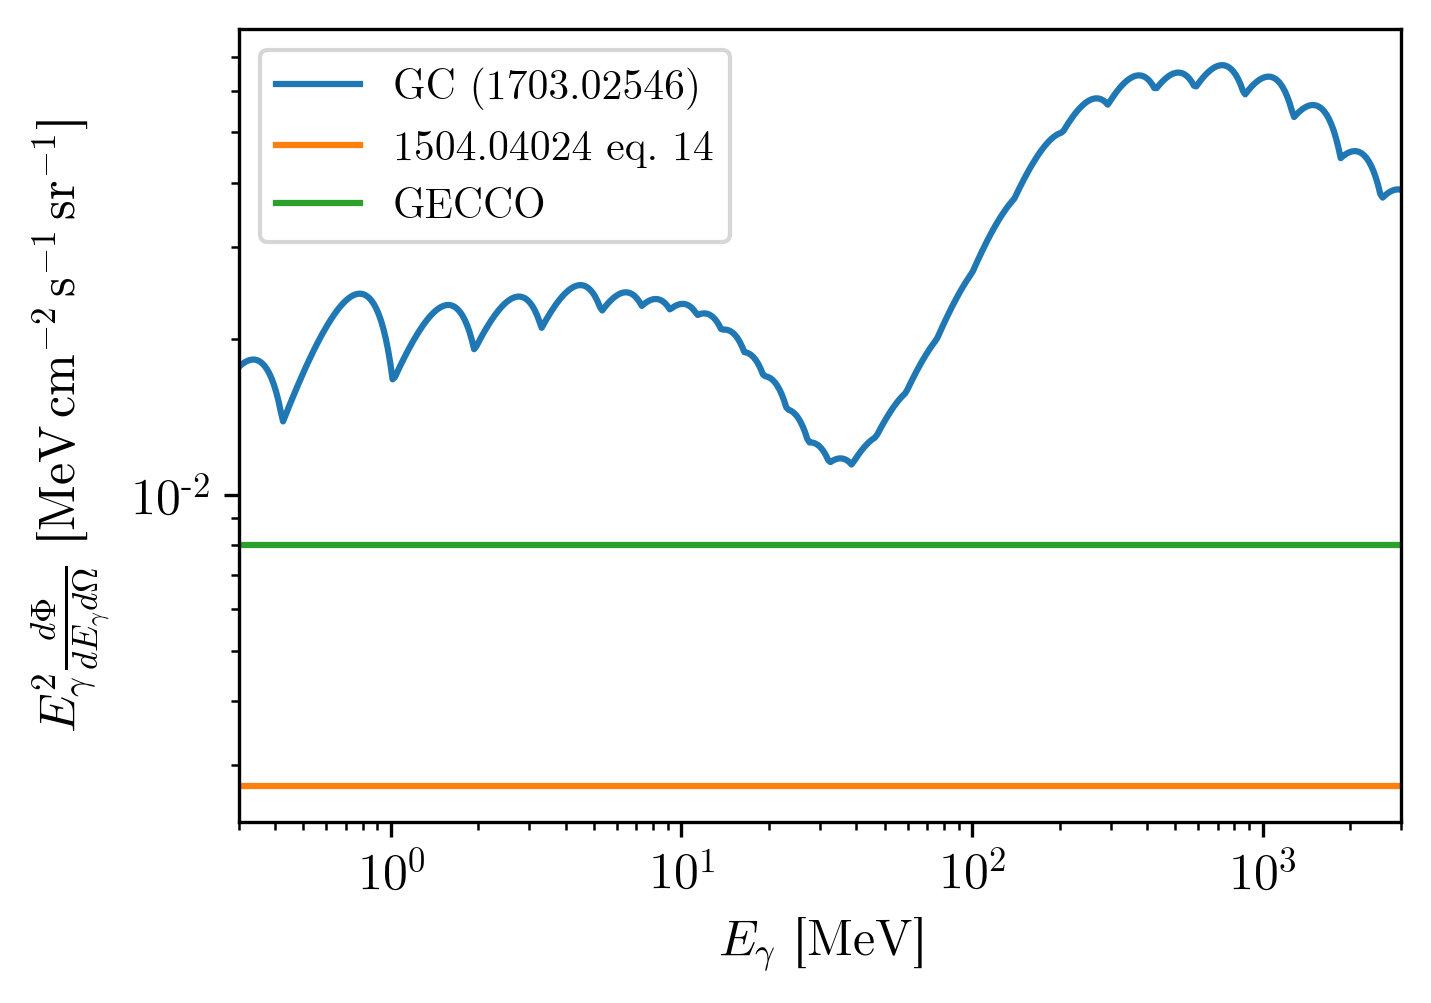

In [35]:
e_gams = np.geomspace(0.3, 3e3, 500)

plt.loglog(e_gams, e_gams**2 * gc_bg_model.dPhi_dEdOmega(e_gams), label="GC (1703.02546)")
plt.loglog(e_gams, e_gams**2 * default_bg_model.dPhi_dEdOmega(e_gams), label="1504.04024 eq. 14")
plt.loglog(e_gams, e_gams**2 * gecco_bg_model.dPhi_dEdOmega(e_gams), label="GECCO")

plt.xlim(e_gams[[0, -1]])
plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$E_\gamma^2 \frac{d\Phi}{dE_\gamma d\Omega}$ [$\mathrm{MeV} \, \mathrm{cm}^{-2} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1}$]")
plt.legend(fontsize=10)

plt.savefig("figures/gecco/bg_models.png")

# Effective areas

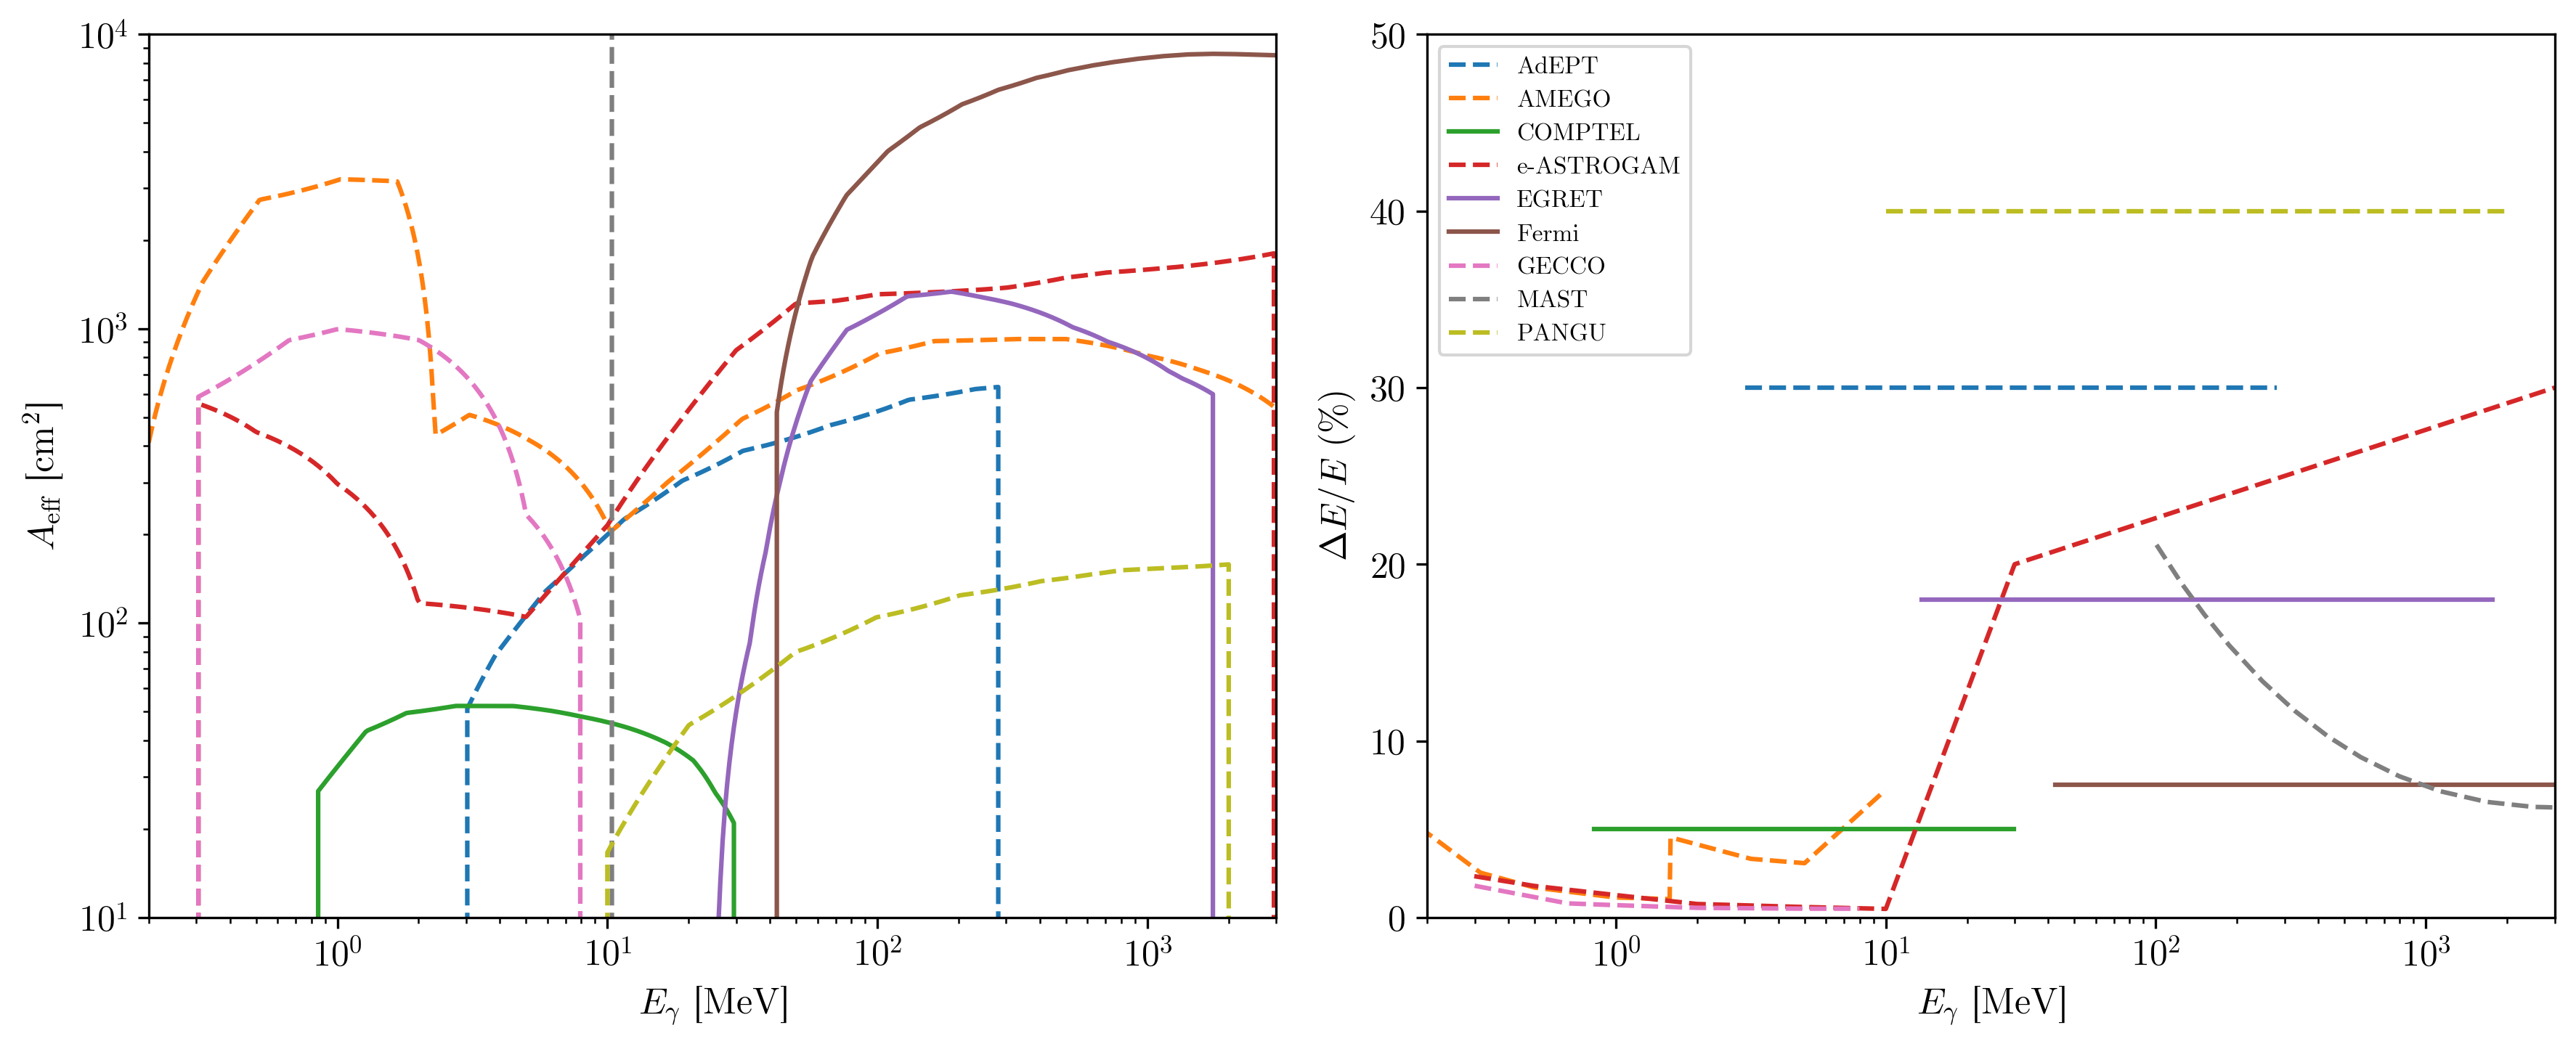

In [17]:
plt.figure(figsize=(12, 5))
e_gams = np.geomspace(0.2, 3e3, 500)

plt.subplot(1, 2, 1)
plt.plot(e_gams, A_eff_adept(e_gams), "--", label="AdEPT")
plt.plot(e_gams, A_eff_amego(e_gams), "--", label="AMEGO")
plt.plot(e_gams, A_eff_comptel(e_gams), label="COMPTEL")
plt.plot(e_gams, A_eff_e_astrogam(e_gams), "--", label="e-ASTROGAM")
plt.plot(e_gams, A_eff_egret(e_gams), label="EGRET")
plt.plot(e_gams, A_eff_fermi(e_gams), label="Fermi")
plt.plot(e_gams, A_eff_gecco(e_gams), "--", label="GECCO")
plt.plot(e_gams, A_eff_mast(e_gams), "--", label="MAST")
plt.plot(e_gams, A_eff_pangu(e_gams), "--", label="PANGU")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$A_\mathrm{eff}$ [cm$^2$]")
plt.xlim(e_gams[[0, -1]])
plt.ylim(1e1, 1e4)
plt.xscale("log")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(A_eff_adept.x, 100 * energy_res_adept(A_eff_adept.x), "--", label="AdEPT")
plt.plot(energy_res_amego.x, 100 * energy_res_amego.y, "--", label="AMEGO")
plt.plot(A_eff_comptel.x, 100 * energy_res_comptel(A_eff_comptel.x), label="COMPTEL")
plt.plot(
    energy_res_e_astrogam.x, 100 * energy_res_e_astrogam.y,
    "--", label="e-ASTROGAM"
)
plt.plot(A_eff_egret.x, 100 * energy_res_egret(A_eff_egret.x), label="EGRET")
plt.plot(A_eff_fermi.x, 100 * energy_res_fermi(A_eff_fermi.x), label="Fermi")
plt.plot(energy_res_gecco.x, 100 * energy_res_gecco.y, "--", label="GECCO")
plt.plot(energy_res_mast.x, 100 * energy_res_mast.y, "--", label="MAST")
plt.plot(A_eff_pangu.x, 100 * energy_res_pangu(A_eff_pangu.x), "--", label="PANGU")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$\Delta E / E$ (%)")
plt.xlim(e_gams[[0, -1]])
plt.ylim(0, 50)
plt.xscale("log")
plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig("figures/gecco/telescope_params.png")

# Energy resolution

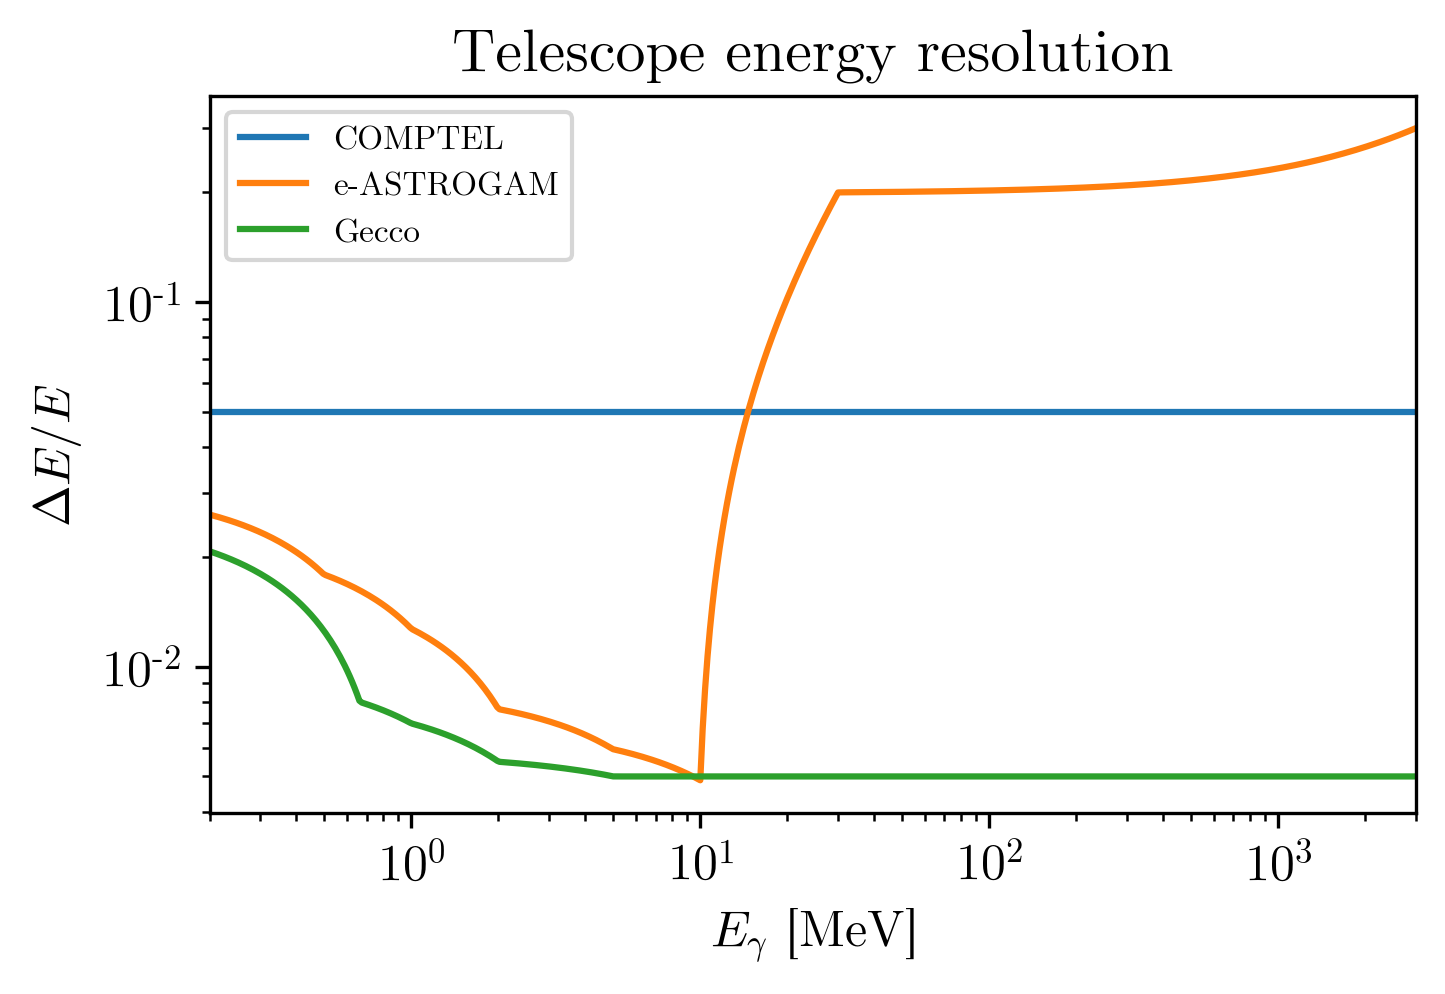

In [32]:
e_gams = np.geomspace(0.2, 3e3, 500)

plt.plot(e_gams, energy_res_comptel(e_gams) * np.ones(len(e_gams)), label="COMPTEL")
plt.plot(e_gams, energy_res_e_astrogam(e_gams), label="e-ASTROGAM")
plt.plot(e_gams, energy_res_gecco(e_gams), label="Gecco")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$\Delta E / E$")
plt.xlim(e_gams[[0, -1]])
# plt.ylim(1e1, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=8)
plt.title("Telescope energy resolution")

plt.tight_layout()
plt.savefig("figures/gecco/energy_res.png")